# Gradient Descend

The most consice concept of learning can be described as a feedback loop.

![asdf](http://www.golfwrx.com/wp-content/uploads/2014/03/The_Feedback_Loop2.jpg)

You set some objective, you make some action, you measure this action. Then you check how the result of the action deviates from what you want to achieve. You then make the corresponding correction: you adapt your action in the direction that reduces the deviation from the objective.

This is how machines learn, too. We have a *(mathematical) objective function* and some data. We then adapt the *parameters* of the *objective function* to better *fit* to the data. **Iteratively**. We finish when we cannot improve our *parameters* anymore.

## Optimization

Although we could directly dive into learning from data, lets move a step back and look into one of the components: optimization. 

In optimization we are trying to find a minimum of a function. Consider the following function $y = f(x) = (x-2)^2 + (x^2 - 6)^2 - 10$. It has one *parameter* $x$ and we will try to find such a $x$ that minimizes the $y$. We surely can solve this analytically, but this is not how most machine learning algorithms work. Instead we implement a general technique that may (!) find a minima of *any* function.



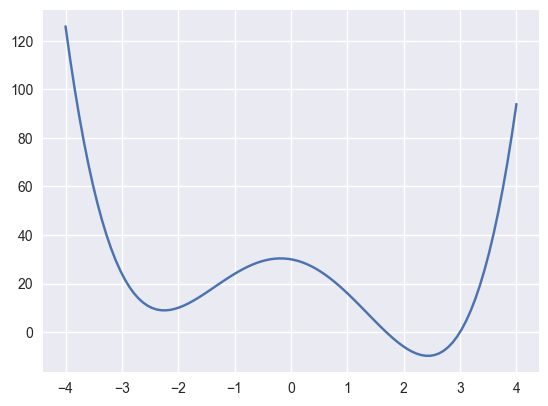

In [26]:
import numpy as np
import matplotlib.pyplot as plt

@np.vectorize
def any_function(x):
    return (x-2)**2 + (x**2 - 6)**2 - 10

x = np.linspace(-4, 4, 100)
y = any_function(x)

curveFigure = plt.figure()
plt.plot(x,y, figure = curveFigure)
plt.show()

Given the feedback loop from above $x$ corresponds to 'Do something', $y$ corresponds to 'Measure'. And 'Analyze' is the central point of optimization - it computes the gradient.

A *gradient* is the *slope* of tangent line at some point. Usually when the slope is '0' at some point, this point is considered an turning point of a function. The global optimum (e.g. the minumum of the function) can be found at *one* (sometimes more but not all) such turning point.

The gradient can be computed by first, computing the derivative of the function, and second, evaluation the derivative at a given point. Since we want the machine to compute the derivative by its own (we could and *sometimes should* but we don't want to supply the derivative) it can simply be computed using the following equation: $g(x) = \frac{f(x + h) - f(x - h)}{2h}$

In [35]:
@np.vectorize
def numerical_derivative(x, f, h = 0.001):
    return (f(x+h) - f(x-h))/(2.0*h)

@np.vectorize
def tangent(x, x_0, any_function):
    y_0 = any_function(x_0)
    m = numerical_derivative(x_0, any_function)
    y = m*(x - x_0) + y_0
    return y


The derivative of a function provides the slope of the tangent at specific point (red). The actual tangent line (green), given a point $(x_0, y_0)$ and slope (the gradient) has the equation $t(x) = g(x_0)(x - x_0) + y_0$

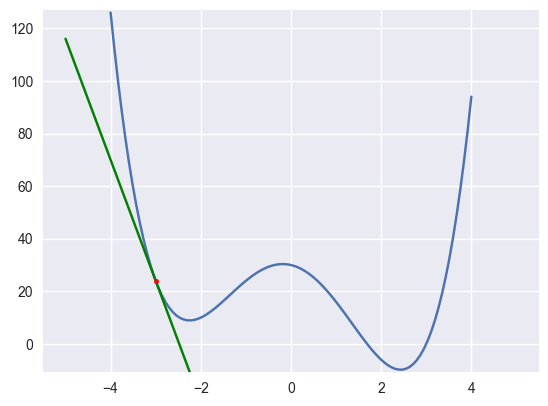

In [42]:
x_range = [min(x)-1, max(x)+1]
xn = -3.
y_range = tangent(x_range, xn, any_function)


plt.plot(x,y)
plt.plot(x_range, y_range, '-g')
plt.plot(xn, any_function(xn), '.r')
plt.ylim(min(y)-1, max(y)+1)
plt.show()

As you may notice in the graph, the gradient 'hints' at the direction of a minimum in the graph. Imagine the red point being a ball that rolls down (on the inside of) the blue curve. The ball's path will follow the tangent line *downwards* till it reaches some point where the slope of the tangent is **zero**.

Given a point $x_t$ we would like to compute new point $x_{t+1}$ in the (negative) direction of the gradient $g(x_t)$. How large the step should be? This quantity or better hyperparameter is called the *learning rate* ($\mu$). So basically our $x_{t+1} = x_{t} - \mu \cdot g(x_t)$

1.6000012


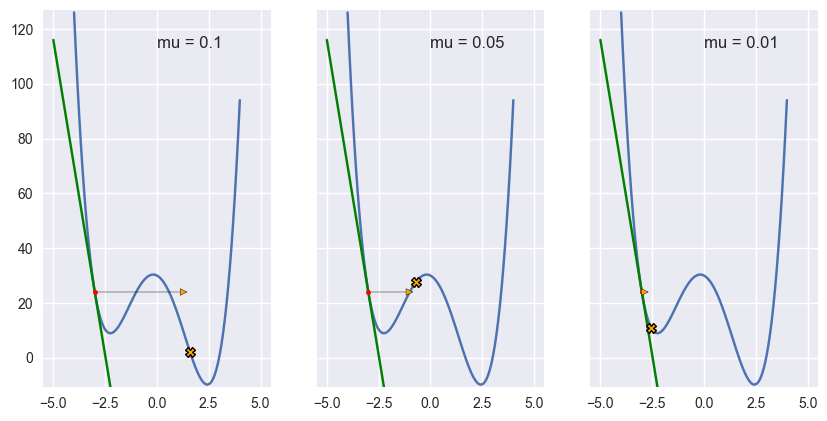

In [132]:
xold = -3
yold = any_function(xold)
x_range = [min(x)-1, max(x)+1]
xold = -3.
y_range = tangent(x_range, xold, any_function)

f, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(10, 5))

for ax, mu in zip(axes, [0.1, .05, 0.01]):
    xnew = xold - mu * numerical_derivative(xold, any_function)
    ax.plot(x,y)
    ax.plot(x_range, y_range, '-g')
    ax.plot(xold, yold, '.r')
    plt.ylim(min(y)-1, max(y)+1)
    ax.plot(xnew, any_function(xnew), '.', c = 'orange', mec = 'black', marker='X', markeredgewidth=1.0)
    ax.annotate(s='', xy=(xold,yold), xytext=(xnew,yold), arrowprops=dict(arrowstyle='<|-', fc = 'orange'))
    ax.text(0.5, 0.9,'mu = %s' % mu, transform = ax.transAxes)


plt.show()


The right choice of $\mu$ is what usually causes the most headache - however it is chosen to be small in many cases.

Now, since the gradient isn't zero (or close to zero) in the next step, the Gradient Descent method continues to run. It terminates when the gradient is close to zero or when a predefined number of iterations has been reached.

In [151]:
np.isclose(0., 0.0000001, atol=1e-02)

True

In [160]:
xn = -3
gx = numerical_derivative(xn, any_function)
iteration = 0
mu = 0.01

while (iteration < 100 and (not np.isclose(0., gx, atol=1e-08))):
    print ('x: %f -> y: %f | g(x): %f @ iter: %d' % (xn, any_function(xn), numerical_derivative(xn, any_function), iteration))
    gx = numerical_derivative(xn, any_function)
    iteration += 1
    xn -= mu * gx
    

x: -3.000000 -> y: 24.000000 | g(x): -46.000012 @ iter: 0
x: -2.540000 -> y: 10.815541 | g(x): -13.668260 @ iter: 1
x: -2.403317 -> y: 9.439409 | g(x): -6.652637 @ iter: 2
x: -2.336791 -> y: 9.098717 | g(x): -3.631654 @ iter: 3
x: -2.300474 -> y: 8.995086 | g(x): -2.087692 @ iter: 4
x: -2.279597 -> y: 8.960463 | g(x): -1.233166 @ iter: 5
x: -2.267266 -> y: 8.948308 | g(x): -0.739628 @ iter: 6
x: -2.259870 -> y: 8.943919 | g(x): -0.447586 @ iter: 7
x: -2.255394 -> y: 8.942308 | g(x): -0.272299 @ iter: 8
x: -2.252671 -> y: 8.941712 | g(x): -0.166190 @ iter: 9
x: -2.251009 -> y: 8.941489 | g(x): -0.101626 @ iter: 10
x: -2.249993 -> y: 8.941406 | g(x): -0.062218 @ iter: 11
x: -2.249370 -> y: 8.941375 | g(x): -0.038119 @ iter: 12
x: -2.248989 -> y: 8.941363 | g(x): -0.023365 @ iter: 13
x: -2.248755 -> y: 8.941358 | g(x): -0.014325 @ iter: 14
x: -2.248612 -> y: 8.941357 | g(x): -0.008784 @ iter: 15
x: -2.248524 -> y: 8.941356 | g(x): -0.005387 @ iter: 16
x: -2.248471 -> y: 8.941356 | g(x): -

With this small learning rate we only converge towards the local mimima

In [267]:
# for animation purposes we need to put some detail into implementation
import collections

class GradientDescend(collections.Iterator):
    """Set up the gradient descent method."""

    def __init__(self, x0, targetFunction, mu = 0.1, **kwargs):
        """Set up the gradient method prarameters."""
        self.targetFunction = targetFunction
        self.x0 = x0
        self.mu0 = mu
        # step initialization
        self.x = x0
        self.y = self.targetFunction(self.x0)
        self._current_iteration = 0
        
    def reset(self):
        self.x = self.x0
        self.y = self.targetFunction(self.x0)
        self._current_iteration = 0
        
    def __iter__(self):
        self.reset()
        return self

    def next(self):
        if self._current_iteration == 0:
            self._current_iteration += 1
            return self.x, self.targetFunction(self.x)
        # print ('x: %f -> y: %f | g(x): %f @ iter: %d' % (self.x, self.targetFunction(self.x), numerical_derivative(self.x, self.targetFunction), self._current_iteration))
        gx = numerical_derivative(self.x, self.targetFunction)
        if self._current_iteration > 100 or (np.isclose(0., gx, atol=1e-08)):
            raise StopIteration
        else:
            self._current_iteration += 1
            self.x -= self.mu0 * gx
            return self.x, self.targetFunction(self.x)

In [274]:
class Animator(object):
    """Animate gradient evolution."""

    def __init__(self, ax, gradientDescendMethod,  fromx = -4, tox = 4, byn = 100):
        self.gradientDescendMethod = gradientDescendMethod
        self._ax = ax
        self._currentstep, = self._ax.plot([], [], '.r')
        self._tangentline, = self._ax.plot([], [], '-g')
        xr = np.linspace(fromx, tox, byn)
        yr = self.gradientDescendMethod.targetFunction(xr)
        self._graph = self._ax.plot(xr, yr, '-b')
        
    def draw(self):
        xnew = self.gradientDescendMethod.x
        ynew = self.gradientDescendMethod.targetFunction(xnew)
        xlim = self._ax.get_xlim()
        ylim = tangent(xlim, xnew, self.gradientDescendMethod.targetFunction)
        self._tangentline.set_data(xlim, ylim)            
        self._currentstep.set_data(xnew, ynew)

    def reset(self):
        self.gradientDescendMethod.reset()
        self.draw()      
        return self._currentstep, self._tangentline,

    def __call__(self, i):
        #print 'a', i
        try:
            self.draw()
        except Exception as e:
            print e

        return self._currentstep, self._tangentline,

In [275]:
# gd = GradientDescend(-3, any_function, mu = 0.02)
# # for i in gd:
#     print i

In [278]:
rc('animation', html='html5')

fig, ax = plt.subplots()
gd = GradientDescend(-4, any_function, mu = 0.03)
ga = Animator(ax, gd)
anim = FuncAnimation(fig, ga, frames = gd, init_func=ga.reset,
                     interval=250)
HTML(anim.to_html5_video())

anim

In [289]:
fig, ax = plt.subplots()
gd = GradientDescend(0, any_function, mu = 0.05)
ga = Animator(ax, gd)
anim = FuncAnimation(fig, ga, frames = gd, init_func=ga.reset,
                     interval=250)
HTML(anim.to_html5_video())
#anim

In [287]:
@interact(x_in = (-4, 4, 0.1), mu = (0.01, 0.1, 0.01))
def interactive_optim(x_in, mu):
    fig, ax = plt.subplots()
    gd = GradientDescend(x_in, any_function, mu = mu)
    ga = Animator(ax, gd)
    anim = FuncAnimation(fig, ga, frames = gd, init_func=ga.reset,
                         interval=250)
    return HTML(anim.to_html5_video())
    #rc('animation', html='html5')
    #anim

In [291]:
plt.clf()
plt.cla()
plt.close()

We can see that find the right starting point and learning rate has a huge impact on whether gradient descend will converge and find the right minima. We cannot directly know where to place the starting point, so that one is out. But we see that at some point it makes sense to adapt the learning rate. And here is where 

## Learning (from data)

Machine learning is ''the study and construction of algorithms that can learn from and make predictions on data''. So basically we have data which we feed into the learning machine and after some time we expect the machine to produce sensible outputs for new data.

Let's break it down what we need:
1. *Training Data* (or simply data) - the is the data which we intially put into our 'Machine Learning System' and we expect it to learn from data
2. Machine Learning System - It consists of a model, objective function, and optimization algorithm
    * Model: a function that transforms input into an output
    * Objective function: This function measures how close our model is given some data to some specified goal.
    * Optimization algorithm: Is a method that iteratively finds such parameters of the objective function that brings us closer to some specified goal.
    
That's basically it: Various problems just are specific realization of the above:
* Regression: finds a curve (linear weighted combination of input variables) that fits the data (points with continous response values) such that the error (mean deviation from the data points) is minimized.
* Classification: finds a separating hypterplane (weighted combination of input variables) that fits the data (points with discrete or categorical labels) such that the accuracy (correct number of labels to points) is maximized
* Clustering: find points (cluster centers) that best (high intra cluster distances, low inter cluster distances) groups data (points).
... and many others.



## Linear regression

Let's take linear regression for example. (Note: [other techniques](https://en.wikipedia.org/wiki/Least_squares#Linear_least_squares) are better suited, but here we just simply demonstrate the Gradient Descend).

Our data may come from the following function $y = f(x) = (x-2)^2 + (x^2 - 6)^2 - 10$. And we may only have measured, say 100, points.

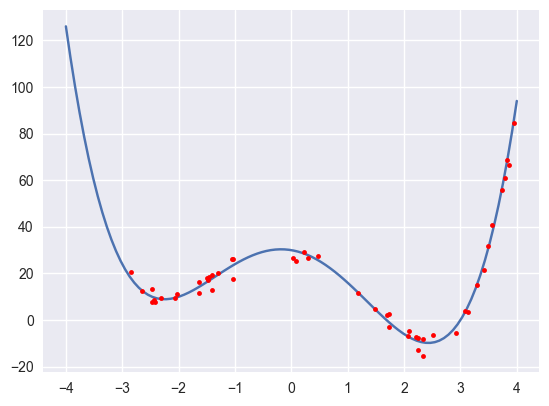

In [23]:
import numpy as np
import matplotlib.pyplot as plt

@np.vectorize
def any_function(x):
    return (x-2)**2 + (x**2 - 6)**2 - 10

x = np.linspace(-4, 4, 100)
y = any_function(x)

datax = np.concatenate((np.random.uniform(-3, -1, 20),
                        np.random.uniform(0, 4, 30)))
# add some noise to the resulting y
datay = any_function(datax) + 3 * np.random.randn(50)


#datax = np.random.uniform(-4 2.5 * np.random.randn(100) + 3

curveFigure = plt.figure()
plt.plot(x,y, figure = curveFigure)
plt.plot(datax, datay, '.r')
plt.show()

So the red points, `datax` = $x$ and `datay` = $y$, is our training data. Now we need to 

In [9]:
from math import sin, cos
from collections import Iterator
import traceback

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from matplotlib.animation import FuncAnimation
from matplotlib import animation, rc
from IPython.display import HTML
from IPython.display import IFrame
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['figure.figsize'] = 6.4, 4.8
mpl.rcParams['figure.dpi'] = 100
   #: 6.4, 4.8   # figure size in inches
#

In [7]:
@np.vectorize
def any_function(x):
    #return (x)**2 + 3*sin(x) - 4*cos((x)**2)
    return (x-2)**2 + (x**2 - 6)**2 - 10
    #return x**2

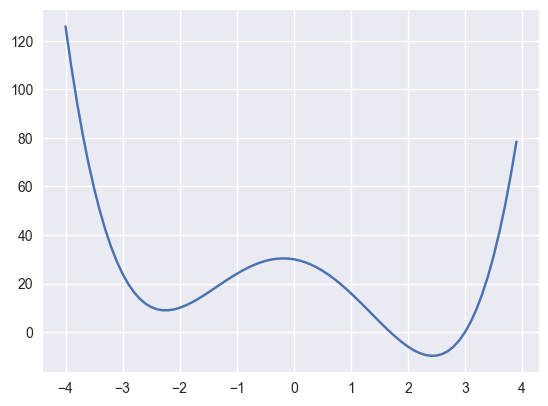

In [8]:
x = np.arange(-4, 4, 0.1)
y = any_function(x)

curveFigure = plt.figure()
plt.plot(x,y, figure = curveFigure)
plt.show()

Next, we need to find the deviation. A very simple and popular method is using [symmetric difference](https://en.wikipedia.org/wiki/Numerical_differentiation).

In [142]:
@np.vectorize
def numerical_derivative(x, f, h = 0.001):
    return (f(x+h) - f(x-h))/(2.0*h)

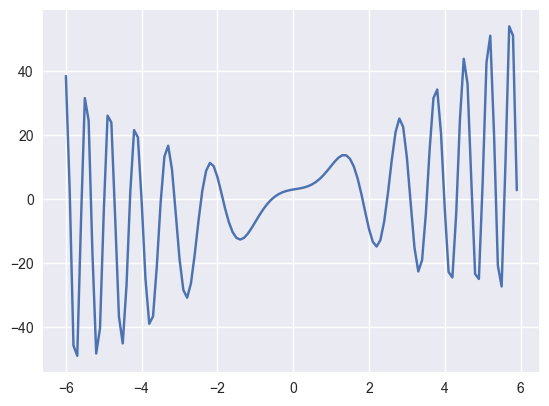

In [143]:
ytick = numerical_derivative(x, any_function)

plt.plot(x,ytick)
plt.show()

Now, we look for an $x$ for which $f'(x) = 0$. Seems like a difficult function to optimize since there are many values where this is the case.

For starters we can choose one point randomly, say $x = 3$, and start our gradient descend - basically we move $x$ to the negative gradient, only scaled by some 'rate' = $\mu$, i.e. $x_{\mathtt{new}} = x_{\mathtt{old}} - \mu * f'(x_{\mathtt{old}})$.

Furthermore, since $f'(x_1)$ is basically the slope of the tangent at $(x_1,y_1)$ we simply can draw it by using the equation $y = f'(x_1)\cdot(x - x_1) + y_1$

In [144]:
@np.vectorize
def tangent(x, x_p, any_function):
    y_p = any_function(x_p)
    m = numerical_derivative(x_p, any_function)
    y = m*(x - x_p) + y_p
    return y

#tangent([min(x), max(x)], xn, any_function)

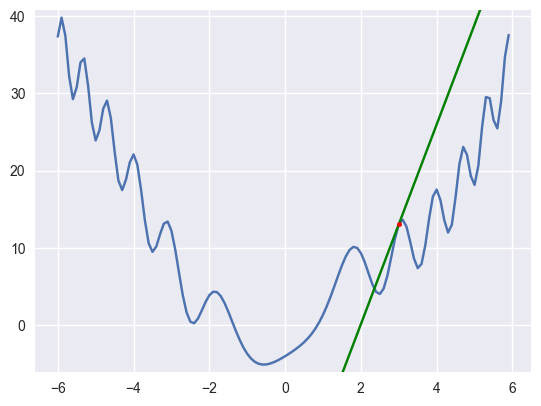

In [145]:
xn = 3
mu = 0.2

x_range = [min(x), max(x)]
y_range = tangent(x_range, xn, any_function)

plt.plot(x,y)
plt.plot(x_range, y_range, '-g')
plt.plot(xn, any_function(xn), '.r')
plt.ylim(min(y)-1, max(y)+1)
plt.show()

xn: 0.415843, f(xn) = -2.555534, f'(xn) = 4.148432
mu = 0.200000


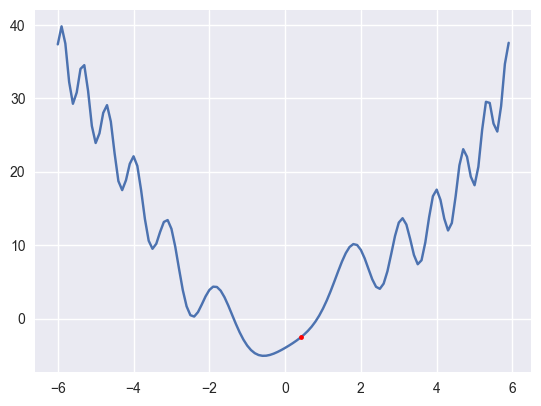

In [146]:
#mu = 0.9*mu
xnew = xn - mu * numerical_derivative(xn, any_function)
xn = xnew

print 'xn: %f, f(xn) = %f, f\'(xn) = %f' % (xn, any_function(xn), numerical_derivative(xn, any_function))
print 'mu = %f' % (mu)
plt.plot(x,y)
plt.plot(xn, any_function(xn), '.r')
plt.show()
# TODO: animate!

In [151]:
class NumericalDerivative(object):
    
    def __init__(self, f, h = 0.0001):
        self.h = h
        self.f = f
        
    def __call__(self, x):
        f, h = self.f, self.h
        return (f(x+h) - f(x-h))/(2.0*h)
    
class GradientMethod(Iterator):
    
    def __init__(self, x0, targetFunction, derivative = None, **kwargs):
        self.targetFunction = targetFunction
        if derivative is None:
            self.derivative = NumericalDerivative(targetFunction)
        
        if 'mu' in kwargs:
            self.mu0 = kwargs['mu']
        else:
            self.mu0 = 0.1#lambda x: x
        
        if 'maxiter' in kwargs:
            self.maxiter = kwargs['maxiter']
        else:
            self.maxiter = 1000
        self.x0 = x0
        ## step initialization
        self._current_iteration = 0 
        self._xnew = x0
        self._ynew = self.targetFunction(self._xnew)
        self._mu = self.mu0

    def reset(self):
        self._current_iteration = 0
        self._xnew = self.x0
        self._ynew = self.targetFunction(self._xnew)
        self._mu = self.mu0
    
    def next(self):
        """Compute xnew and ynew.
        
        Terminate if y and ynew are close to each other or we reached the upper limit of iterations.
        """
        
        ftick_x = self.derivative(self._xnew)
        xn = self._xnew - self._mu * ftick_x
        # Newton's method
        #xn = self._xnew - self._ynew/ftick_x
        yn = self.targetFunction(xn)
        if np.isclose(yn, self._ynew, rtol=1e-08, atol=1e-12) or (self._current_iteration > self.maxiter):
            raise StopIteration
        else:
            self._ynew = yn
            self._xnew = xn
            self._current_iteration += 1
            #print 'New x: %f, y: %f' % (self._xnew, self._ynew)
            return self._xnew, self._ynew
    
    def tangent(self, xlim):
        x = np.asarray(xlim)
        return self.derivative(self._xnew)*(x - self._xnew) + self._ynew
    

class GMIterator(object):
    
    def __init__(self, gm):
        self.gm = gm   

    def __iter__(self):
        self.gm.reset()
        return self.gm
    
    
class GMAnimator(GMIterator):
    
    def __init__(self, ax, *args):
        GMIterator.__init__(self, *args)
        self._ax = ax
        self._currentstep, = self._ax.plot([], [], '.r')
        self.tangent, = self._ax.plot([], [], '-g')
        
    def reset(self):
        self._currentstep.set_data([], [])
        self.tangent.set_data([], [])
        self.gm.reset()
        return self._currentstep, 
            
    def __call__(self, i):
        try:
            xlim = self._ax.get_xlim()
            ylim = self.gm.tangent(xlim)
            self.tangent.set_data(xlim, ylim)
            self._currentstep.set_data(self.gm._xnew, self.gm._ynew)
        except Exception as e:
            print e
        
        return self._currentstep, self.tangent



In [152]:
#gm = GradientMethod(3.9, any_function)
#for k in GMIterator(gm):
#    print k

In [153]:
#gm = GradientMethod(3.1, any_function, mu = 0.03)
gm = GradientMethod(3.1, any_function, mu = 0.1) # super convergence
#gm = GradientMethod(3.1, any_function, mu = 0.4) # divergence
#gm = GradientMethod(3.1, any_function, mu = 0.01, maxiter = 5000) # very slow convergence
fig, ax = plt.subplots()
ax.plot(x,y)
#ax.set_xlim(-5, 5)
#ax.set_ylim(min(y)-1, max(y)+1)
ax.grid(True)
gma = GMAnimator(ax, gm)
gmi = GMIterator(gm)


anim = FuncAnimation(fig, gma, frames = gmi, init_func=gma.reset,
                     interval=100)
HTML(anim.to_html5_video())
rc('animation', html='html5')
anim

This example shows very nicely that altought we are close at finding the minimum we still have trouble to converge. This is due to the fixed learning rate. Hence, it is sensible to reduce the learning rate with time, e.g. by using exponetial decay $\mu = \mu_0*e^{-kt}$ ([see for others](http://cs231n.github.io/neural-networks-3/#anneal)).

In [22]:
def decay_exp(mu_0, t, k):
    return mu_0 * np.exp(-k*t)


def optimize_simple(f, x, mu, mudecay = decay_exp, k = 1, maxiter = 1000, eps = 0.001):
    y = f(x)
    i = 1
    yn = np.inf
    
    xhist = [x]
    yhist = [y]
    gradhist = [np.inf]
    
    mu_act = mudecay(mu, 0, k)
    while (not np.isclose(y, yn, rtol=1e-08, atol=1e-12)) and (i < maxiter):
        y = yn
        ftick_x = numerical_derivative(x, f)
        x = x - mu_act * ftick_x
        yn = f(x)
        
        xhist.append(x)
        yhist.append(yn)
        gradhist.append(ftick_x)
        
        mu_act = mudecay(mu, i, k)
        i += 1
    
    
   
    return xhist, yhist, gradhist
    

22


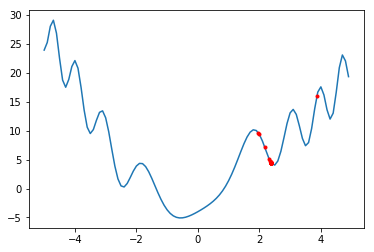

In [34]:
plt.plot(x,y)
xhist, yhist, gradhist = optimize_simple(any_function, 2, 0.2)
print len(xhist)
plt.plot(xhist, yhist, '.r')
    
plt.show()

In [279]:
#def a_fun(x):
#    return x**2 + 2# + 3*(x*np.abs(sin(x)))

#any_function = np.vectorize(a_fun, otypes=[np.float])

@interact(x_in = (-4, 4, 0.1), mu = (0.01, 1, 0.01), k = (0.01, 5, 0.01))
def interactive_optim(x_in, mu, k):
    xhist, yhist, gradhist = optimize_simple(any_function, x_in, mu, k=k)
    xx = np.arange(min(xhist), max(xhist), 0.01)
    yy = any_function(xx)
    print len(xhist)
    print 'Solution at %f (%f) is %f (%f)' % (xhist.pop(), xhist.pop(), yhist.pop(), yhist.pop())
    plt.plot(xx,yy)
    plt.plot(xhist, yhist, '.r')   
    plt.show()


## Linear Regression Example

A simple Linear Regression based on Least Squares is usually solved by  $\mathbf{w} = (\mathbf{X}\mathbf{X}^T)^{-1}\mathbf{X}\hat{y}$ - i.e. it requires (relatively) expensive operation like matrix multiplication and matrix inverse. Sometimes the data is large and using linear algebra is simply not possible.

Gradiens come to help! By using Gradient Descent on the Squared Loss $E = \frac{1}{2}\sum\limits_{\mathbf{x}_i \in \mathbf{X}} (f(\mathbf{x}_i) - y)^2$ we may be able to find hopefully the right weights. 

The derivative of $E$ with respect to a 'weight' $w_i$ in $f(\cdot)$ is $ E'_{w_i} = \frac{dE}{dw_i}$


## Notes

An alternative approach is to comptue the gradient using [Automatic Differentiation](https://pypi.python.org/pypi/ad)

In [138]:
class NumericalDerivative(object):
    
    def __init__(self, f, h = 0.0001):
        self.h = h
        self.f = f
        
    def __call__(self, x):
        f, h = self.f, self.h
        return (f(x+h) - f(x-h))/(2.0*h)
    
class GradientMethod(Iterator):
    
    def __init__(self, x0, targetFunction, derivative = None, **kwargs):
        self.targetFunction = targetFunction
        if derivative is None:
            self.derivative = NumericalDerivative(targetFunction)
        
        if 'mu' in kwargs:
            self.mu0 = kwargs['mu']
        else:
            self.mu0 = 0.1#lambda x: x
        
        if 'maxiter' in kwargs:
            self.maxiter = kwargs['maxiter']
        else:
            self.maxiter = 1000
        self.x0 = x0
        ## step initialization
        self._current_iteration = 0 
        self._xnew = x0
        self._ynew = self.targetFunction(self._xnew)
        self._mu = self.mu0

    def reset(self):
        self._current_iteration = 0
        self._xnew = self.x0
        self._ynew = self.targetFunction(self._xnew)
        self._mu = self.mu0
        
    def __iter__(self):
        self.reset()
        return self
    
    def next(self):
        """Compute xnew and ynew.
        
        Terminate if y and ynew are close to each other or we reached the upper limit of iterations.
        """
        
        ftick_x = self.derivative(self._xnew)
        # GD update
        #xn = self._xnew - self._mu * ftick_x
        # Newton's method
        xn = self._xnew - self._ynew/ftick_x
        yn = self.targetFunction(xn)
        if np.isclose(yn, self._ynew, rtol=1e-08, atol=1e-12) or (self._current_iteration > self.maxiter):
            raise StopIteration
        else:
            self._ynew = yn
            self._xnew = xn
            self._current_iteration += 1
            #print 'New x: %f, y: %f' % (self._xnew, self._ynew)
            return self._xnew, self._ynew
    
    def tangent(self, xlim):
        x = np.asarray(xlim)
        return self.derivative(self._xnew)*(x - self._xnew) + self._ynew
    
    
class GMAnimator(object):
    
    def __init__(self, ax, gm):
        #GradientMethod.__init__(self, *args)
        self.gm = gm
        self._ax = ax
        self._currentstep, = self._ax.plot([], [], '.r')
        self.tangent, = self._ax.plot([], [], '-g')
        
    def reset(self):
        self._currentstep.set_data([], [])
        self.tangent.set_data([], [])
        self.gm.reset()
        return self._currentstep, 
            
    def __call__(self, i):
        print 'a', i
        try:
            xlim = self._ax.get_xlim()
            ylim = self.gm.tangent(xlim)
            self.tangent.set_data(xlim, ylim)
            self._currentstep.set_data(self.gm._xnew, self.gm._ynew)
        except Exception as e:
            print e
        
        return self._currentstep, self.tangent



In [139]:
gm = GradientMethod(3.1, any_function, mu = 0.1) # super convergence
for i in gm:
    print i
gm.reset()
#gm = GradientMethod(3.1, any_function, mu = 0.4) # divergence
#gm = GradientMethod(3.1, any_function, mu = 0.01, maxiter = 5000) # very slow convergence
fig, ax = plt.subplots()
ax.plot(x,y)
#ax.set_xlim(-5, 5)
#ax.set_ylim(min(y)-1, max(y)+1)
ax.grid(True)
gma = GMAnimator(ax, gm)
#gmi = GMIterator(gm)


anim = FuncAnimation(fig, gma, frames = gm, init_func=gma.reset,
                     interval=100)
HTML(anim.to_html5_video())
rc('animation', html='html5')
anim

(1.550000000003493, array(2.4025000000108285))
(0.77500000000174651, array(0.6006250000027071))
(0.38750000000087326, array(0.15015625000067678))
(0.19375000000043663, array(0.037539062500169196))
(0.096875000000209641, array(0.009384765625040618))
(0.04843750000010482, array(0.0023461914062601545))
(0.024218750000053493, array(0.000586547851565091))
(0.012109375000026748, array(0.0001466369628912728))
(0.0060546875000133393, array(3.665924072281778e-05))
(0.0030273437500066783, array(9.164810180704498e-06))
(0.0015136718750033348, array(2.2912025451761113e-06))
(0.00075683593750166796, array(5.728006362940287e-07))
(0.00037841796875083409, array(1.4320015907350725e-07))
(0.00018920898437541702, array(3.58000397683768e-08))
(9.4604492187708495e-05, array(8.950009942094198e-09))
(4.7302246093854247e-05, array(2.2375024855235495e-09))
(2.3651123046927127e-05, array(5.593756213808875e-10))
(1.1825561523463562e-05, array(1.3984390534522184e-10))
(5.9127807617317852e-06, array(3.49609763363